In [40]:
import os
os.environ["JAX_ENABLE_X64"] = "1"
os.environ["JAX_NUM_CPU_DEVICES"] = "2"

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import jax.numpy as jnp
import bambi as bmb

az.style.use("arviz-darkgrid")
SEED = 3990


In [41]:
pokemon_df = pl.read_csv("./data/Pokemon.csv")
typing = ["Type 1", "Type 2"]
ability = ["HP", "Attack", "Defense", "Sp.Atk", "Sp.Def", "Speed"]

In [42]:
old_col = [
    'HP', 'Attack', 'Defense',
    'Sp.Atk', 'Sp.Def', 'Speed'
]

new_col = [
        'clr_HP', 'clr_Attack', 'clr_Defense',
        'clr_SpAtk', 'clr_SpDef', 'clr_Speed'
    ]


closed_pokemon_df = pokemon_df.with_columns(
    pl.col(old_col) / pl.col("Total")
)

closed_pokemon_df.shape

(800, 13)

In [43]:
# columns = [HP, Attack, Defense, SpAtk, SpDef, Speed]
sbp = [
    ([2, 5], [0, 1, 3, 4]),  # B1: {Defense, Speed} vs {HP, Attack, SpAtk, SpDef}
    ([5],    [2]),           # B2: {Speed} vs {Defense}
    ([1, 3, 4], [0]),        # B3: {Attack, SpAtk, SpDef} vs {HP}
    ([4],    [1, 3]),        # B4: {SpDef} vs {Attack, SpAtk}
    ([3],    [1])            # B5: {SpAtk} vs {Attack}
]

def ilr_from_sbp(X, sbp):
    """
    X: (n, D) compositions (rows sum to 1; strictly >0)
    sbp: list of (pos_idx, neg_idx) index lists
    returns Z: (n, D-1) ILR balances
    """
    Z = []
    logX = np.log(X)
    for pos, neg in sbp:
        r, s = len(pos), len(neg)
        gm_pos = np.exp(logX[:, pos].mean(axis=1))
        gm_neg = np.exp(logX[:, neg].mean(axis=1))
        coef = np.sqrt((r * s) / (r + s))
        Z.append(coef * (np.log(gm_pos) - np.log(gm_neg)))
    return np.column_stack(Z)


In [44]:
ilr_df = ilr_from_sbp(closed_pokemon_df[old_col].to_numpy(), sbp)

In [45]:
unique_typing = set(pokemon_df["Type 1"].unique().to_list() + pokemon_df["Type 2"].unique().to_list()) - set([None])

pokemon_df = pokemon_df.with_columns(
    pl.concat_list([pl.col("Type 1"), pl.col("Type 2")])
    .list.drop_nulls()
    .list.sort()
    .list.join(", ")
    .alias("CombinedTyping")
)
pokemon_df.head()

combined_typing = pokemon_df["CombinedTyping"].unique().to_list()
pokemon_df.head()

#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp.Atk,Sp.Def,Speed,Generation,Legendary,CombinedTyping
i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,bool,str
1,"""Bulbasaur""","""Grass""","""Poison""",318,45,49,49,65,65,45,1,false,"""Grass, Poison"""
2,"""Ivysaur""","""Grass""","""Poison""",405,60,62,63,80,80,60,1,false,"""Grass, Poison"""
3,"""Venusaur""","""Grass""","""Poison""",525,80,82,83,100,100,80,1,false,"""Grass, Poison"""
3,"""VenusaurMega Venusaur""","""Grass""","""Poison""",625,80,100,123,122,120,80,1,false,"""Grass, Poison"""
4,"""Charmander""","""Fire""",null,309,39,52,43,60,50,65,1,false,"""Fire"""


In [46]:
# Dimension ILR 1
model_df = pd.DataFrame({
        "B1": ilr_df[:, 0],
        "B2": ilr_df[:, 1],
        "B3": ilr_df[:, 2],
        "B4": ilr_df[:, 3],
        "B5": ilr_df[:, 4],
        "Type 1": pokemon_df["Type 1"].to_list(),
        "Type 2": pokemon_df["Type 2"].to_list(),
        "CombinedTyping": pokemon_df["CombinedTyping"].to_list()
    })

model_df.head()

,B1,B2,B3,B4,B5,Type 1,Type 2,CombinedTyping
0,-0.187723,-0.060216,0.236889,0.115357,0.199805,Grass,Poison,"Grass, Poison"
1,-0.147390,-0.034500,0.175559,0.104059,0.180236,Grass,Poison,"Grass, Poison"
2,-0.114706,-0.026031,0.135960,0.081017,0.140326,Grass,Poison,"Grass, Poison"
3,-0.054931,-0.304167,0.303283,0.067684,0.140609,Grass,Poison,"Grass, Poison"
4,0.072169,0.292167,0.279128,-0.090444,0.101188,Fire,None,Fire


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: random_make_inplace
ERROR (pytensor.graph.rewriting.basic): node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/techen/biosustain/course/bayesian_statistics/pokemon/.venv/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/techen/biosustain/course/bayesian_statistics/pokemon/.venv/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/techen/biosustain/course/bayesian_statistics/pokemon/.venv/lib/python3.12/site-packages/

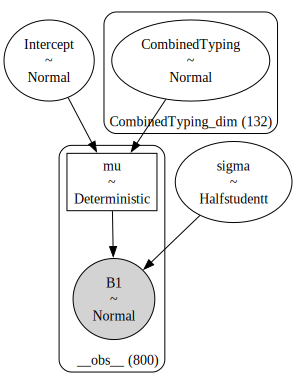

In [47]:
model = bmb.Model(
    "B1 ~ CombinedTyping",
    data = model_df,
    family="gaussian" 
)
model.build()

model.graph()

Sampling: [CombinedTyping, Intercept, sigma]
/Users/techen/biosustain/course/bayesian_statistics/pokemon/.venv/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (134) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Electric'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Fighting'}>],
       [<Axes: title={'center': 'CombinedTyping\nBug, Fire'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Flying'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Ghost'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Grass'}>],
       [<Axes: title={'center': 'CombinedTyping\nBug, Ground'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Poison'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Rock'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Steel'}>],
       [<Axes: title={'center': 'CombinedTyping\nBug, Water'}>,
        <Axes: title={'center': 'CombinedTyping\nDark'}>,
        <Axes: title={'center': 'CombinedTyping\nDark, Dragon'}>,
        <Axes: title={'center': 'CombinedTyping\nDark, Fighting'}>],
   

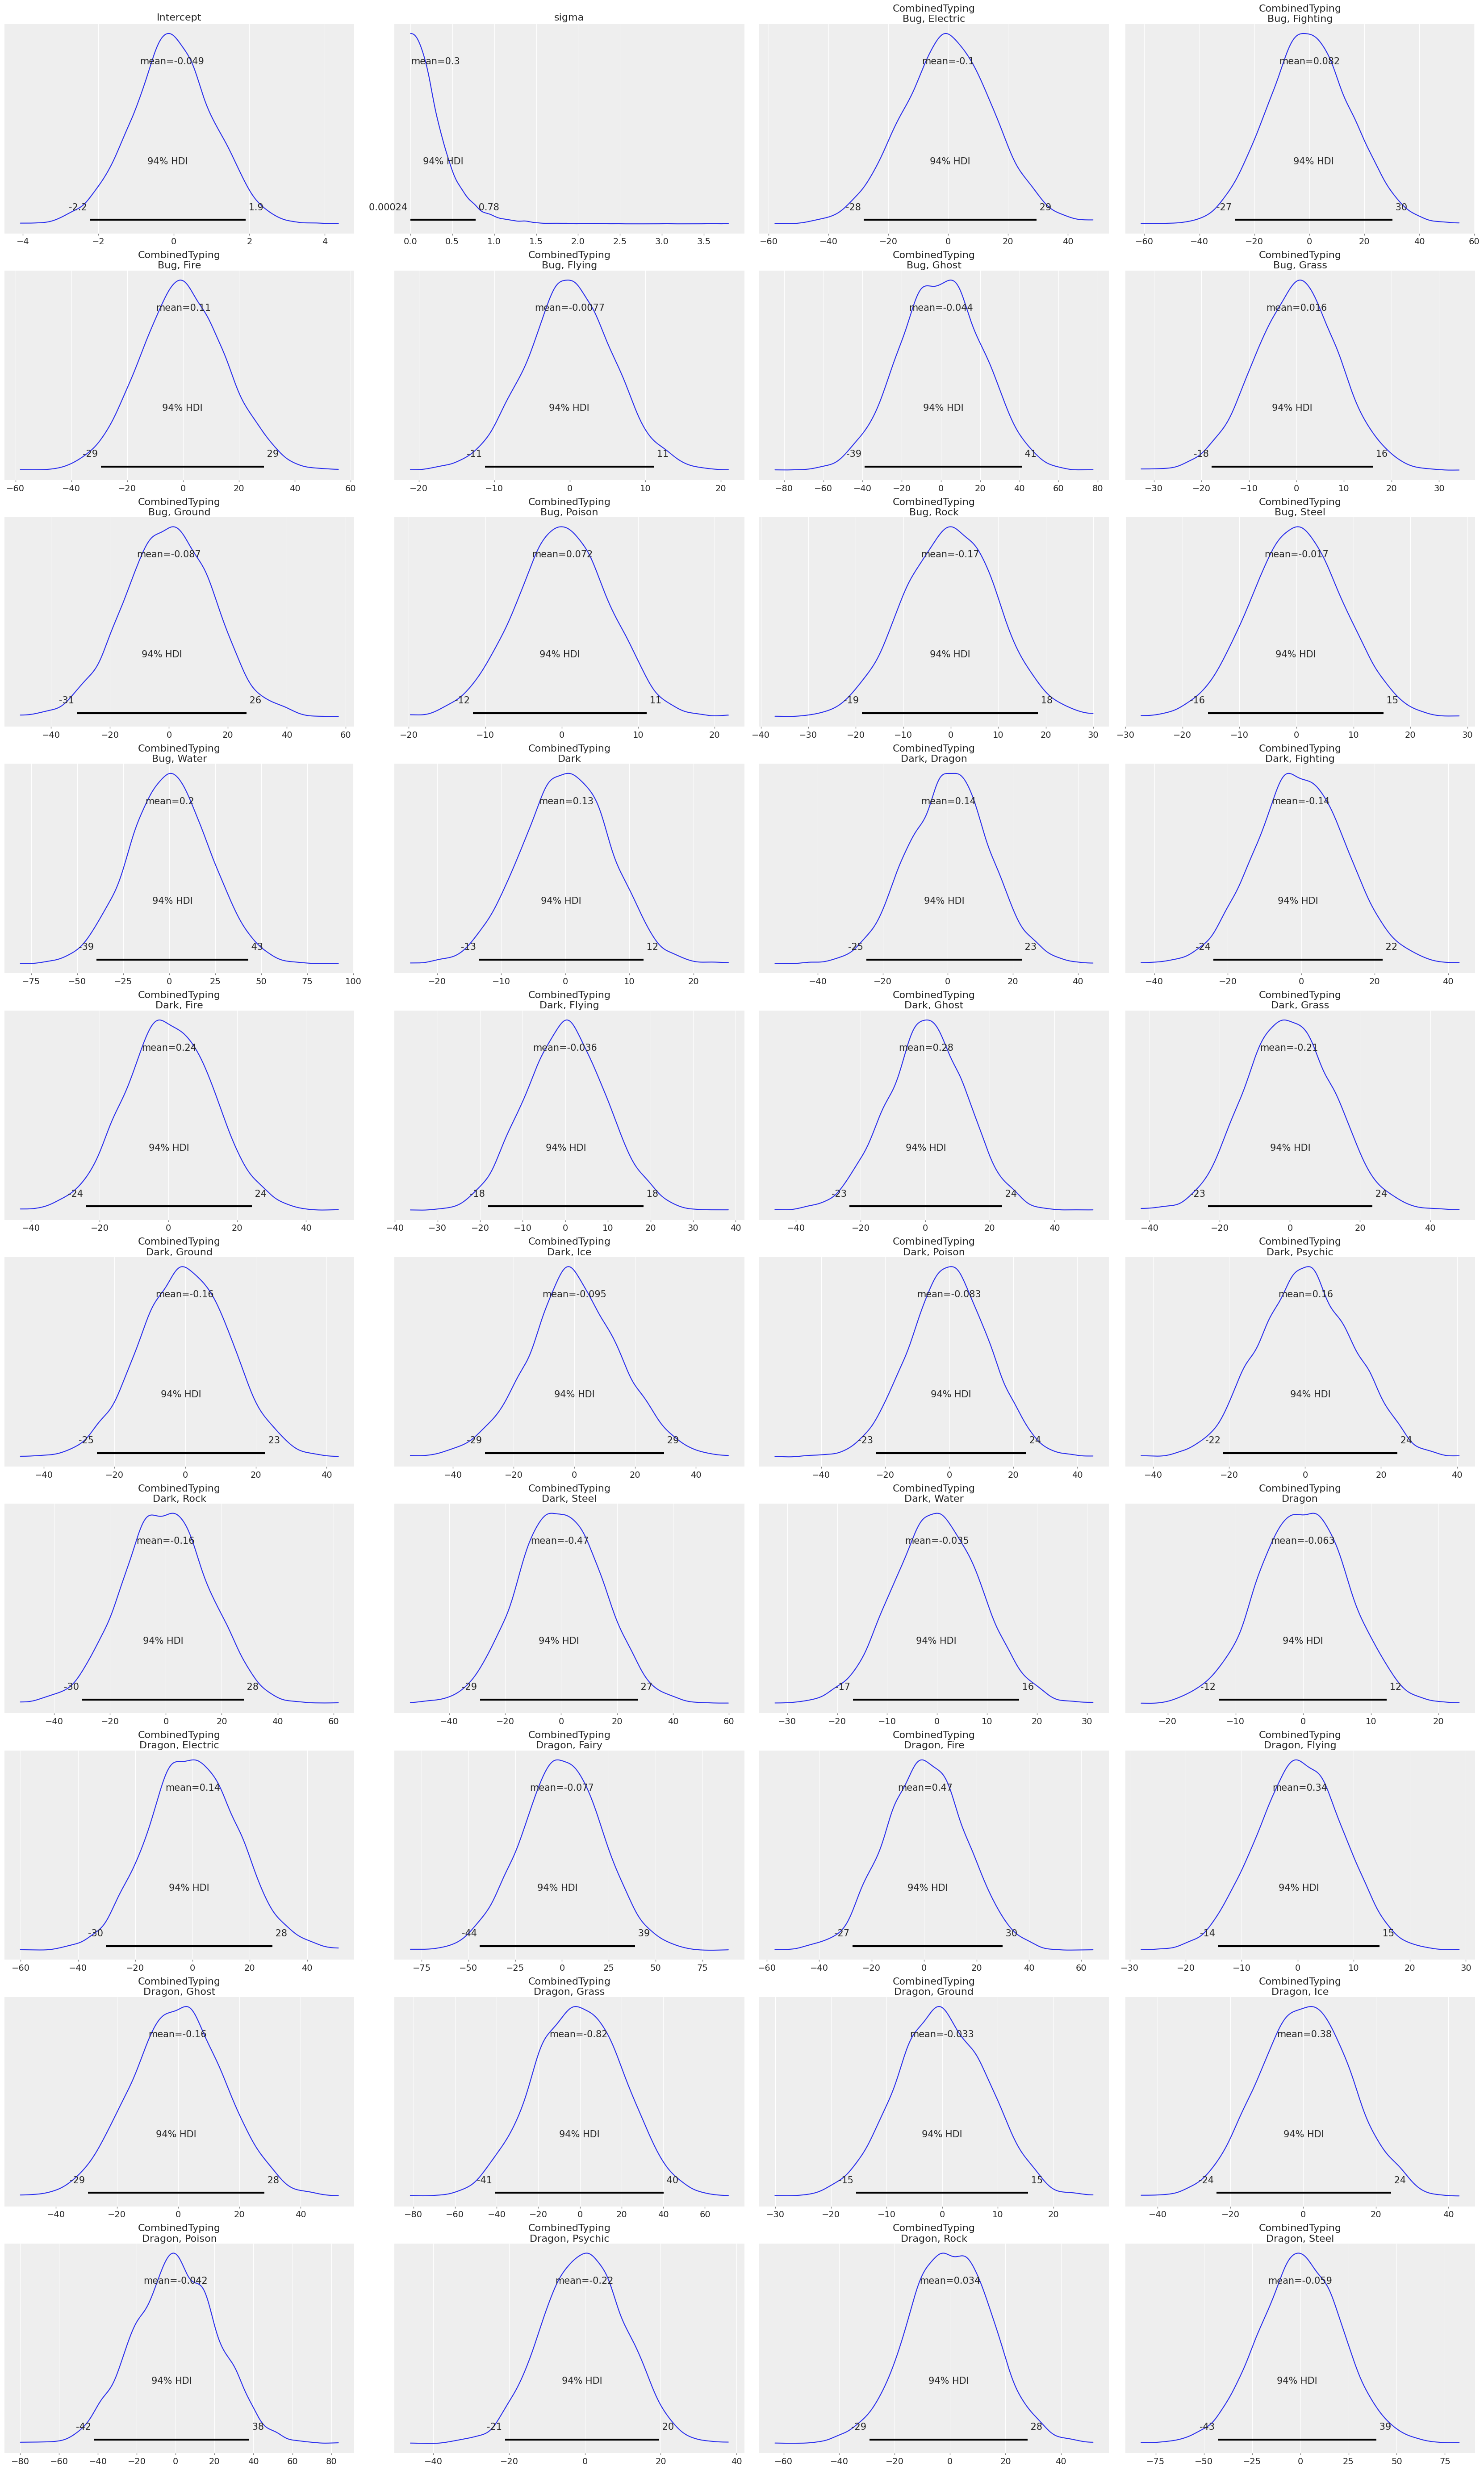

In [55]:
model.plot_priors()

In [48]:
idata = model.fit(
    draws = 2000,
    chains = 4,
    cores = 1,
    random_seed = SEED,
    backend = "jax"
)

az.summary(idata, var_names=["CombinedTyping", "sigma"])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, Intercept, CombinedTyping]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"CombinedTyping[Bug, Electric]",0.043,0.212,-0.359,0.423,0.005,0.002,2216.0,4549.0,1.00
"CombinedTyping[Bug, Fighting]",-0.029,0.216,-0.432,0.377,0.005,0.003,2244.0,4472.0,1.00
"CombinedTyping[Bug, Fire]",-0.165,0.212,-0.566,0.232,0.004,0.002,2544.0,4256.0,1.00
"CombinedTyping[Bug, Flying]",-0.012,0.103,-0.208,0.179,0.004,0.002,606.0,1338.0,1.01
"CombinedTyping[Bug, Ghost]",1.003,0.298,0.439,1.557,0.005,0.003,4089.0,5746.0,1.00
...,...,...,...,...,...,...,...,...,...
"CombinedTyping[Rock, Water]",0.025,0.115,-0.202,0.232,0.004,0.002,667.0,1307.0,1.01
CombinedTyping[Steel],0.019,0.148,-0.259,0.289,0.004,0.002,1120.0,2953.0,1.00
"CombinedTyping[Steel, Water]",-0.372,0.301,-0.921,0.192,0.006,0.004,2933.0,5028.0,1.00
CombinedTyping[Water],-0.026,0.079,-0.178,0.122,0.004,0.002,365.0,643.0,1.01


In [ ]:
idata.sample_stats.diverging.sum().item() > 0

False

In [72]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

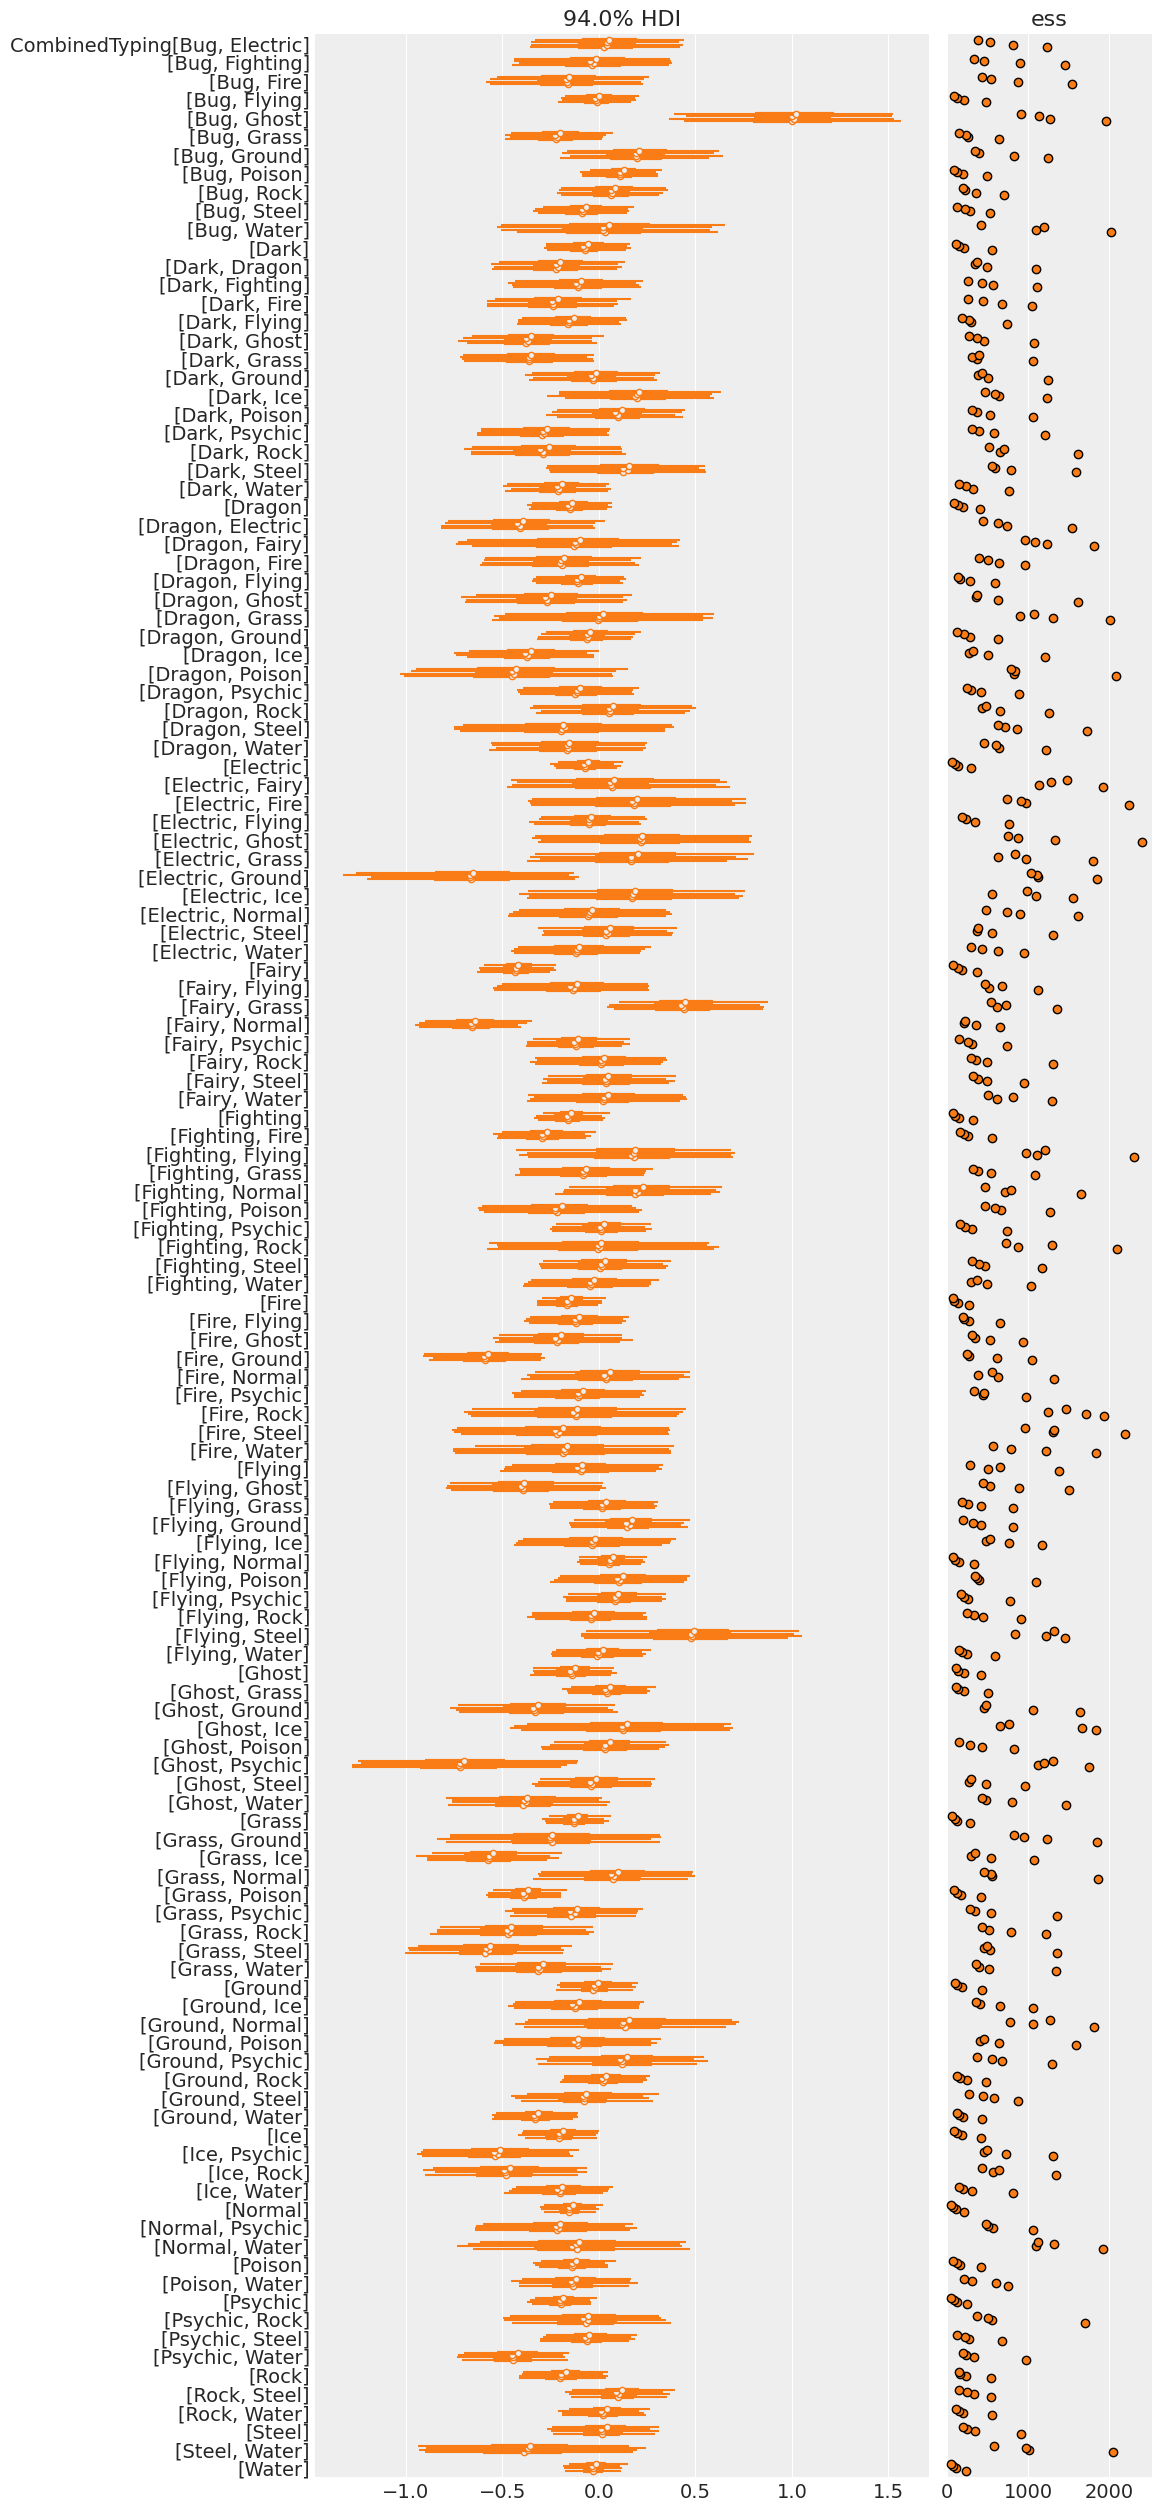

In [81]:
ax = az.plot_forest(
    idata,
    var_names=["CombinedTyping"],
    figsize=(11.5, 25),
    colors="C1",
    ess=True,
)

plt.show()

array([[<Axes: title={'center': 'CombinedTyping'}>,
        <Axes: title={'center': 'CombinedTyping'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

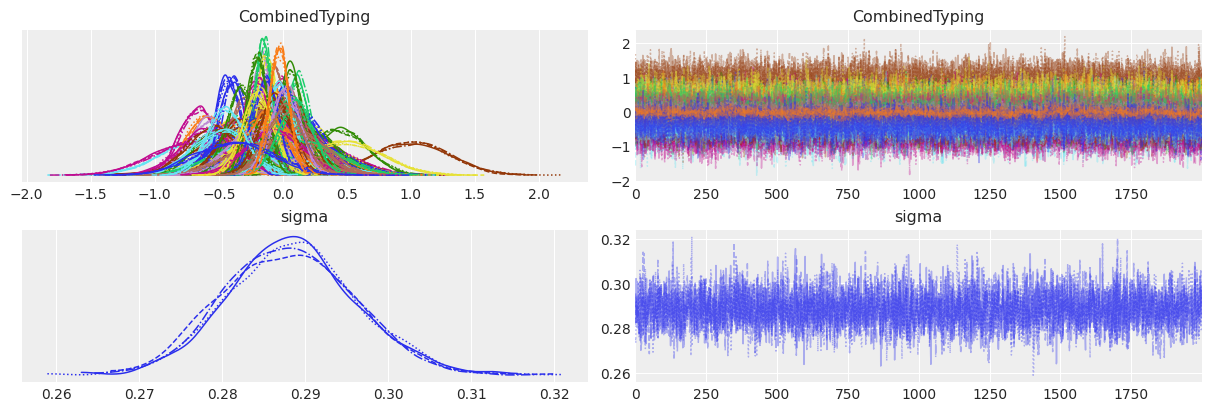

In [75]:
az.plot_trace(
    idata,
    var_names=["CombinedTyping", "sigma"],
    compact=True,    
)

/Users/techen/biosustain/course/bayesian_statistics/pokemon/.venv/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (134) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Electric'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Fighting'}>],
       [<Axes: title={'center': 'CombinedTyping\nBug, Fire'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Flying'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Ghost'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Grass'}>],
       [<Axes: title={'center': 'CombinedTyping\nBug, Ground'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Poison'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Rock'}>,
        <Axes: title={'center': 'CombinedTyping\nBug, Steel'}>],
       [<Axes: title={'center': 'CombinedTyping\nBug, Water'}>,
        <Axes: title={'center': 'CombinedTyping\nDark'}>,
        <Axes: title={'center': 'CombinedTyping\nDark, Dragon'}>,
        <Axes: title={'center': 'CombinedTyping\nDark, Fighting'}>],
   

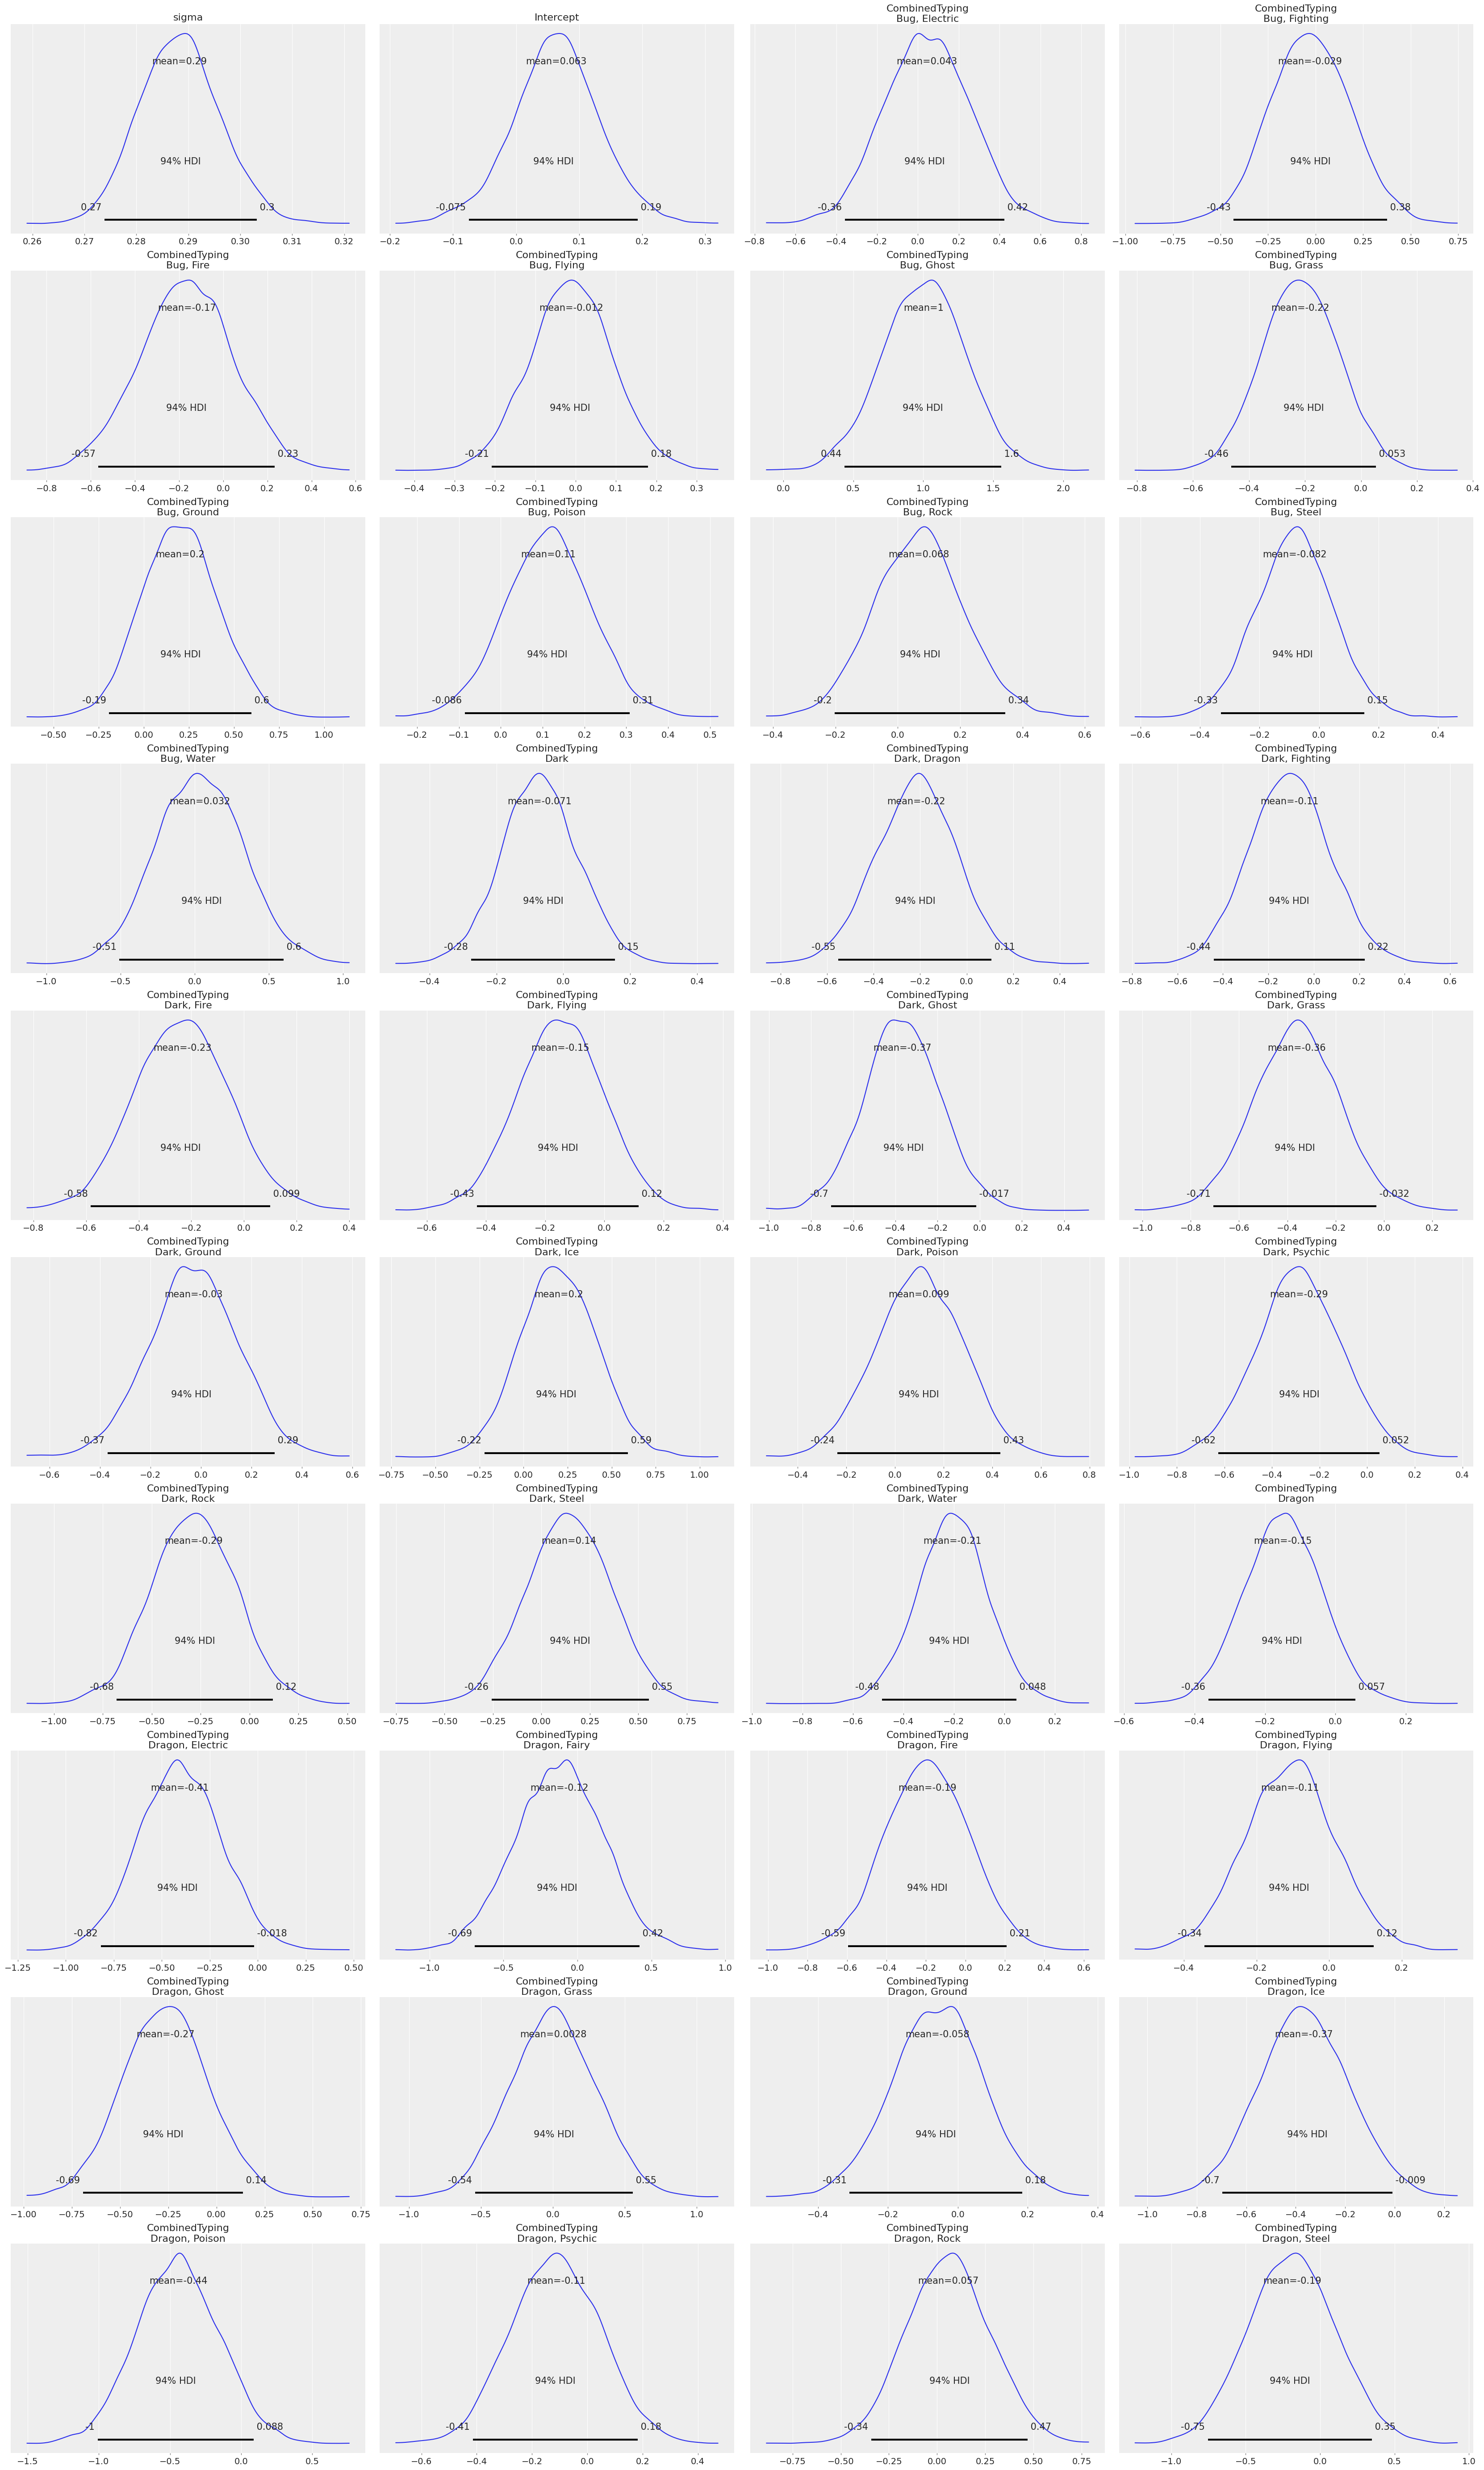

In [64]:
az.plot_posterior(idata)